In [1]:
import os


In [2]:
from  dotenv import load_dotenv
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent


In [5]:

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [6]:
@tool
def check_traffic():
    """this method will be initiated by the driver and it will check the traffic in the route which is to be travelled by the driver"""
    return f"Checking traffic for the route..." 

@tool
def calculate_alternative_route():
    """this method will use llm andd logisitcs api to find the next fastest route """    
    return f"Calculating alternative route..."

@tool
def notify_passenger_and_driver():
    """this method will notify the passenger and driver about the traffic situation and alternative route"""
    return f"Notifying passenger and driver about the traffic situation and alternative route..."


@tool
def check_flight_status():
    """this method will check the status of the flight """
    return f"Checking flight status..."



In [10]:
tools=["check_traffic", "calculate_alternative_route", "notify_passenger_and_driver", "check_flight_status"]


In [11]:
class State(MessagesState):
    next:str

In [15]:
tools = ["check_traffic", "calculate_alternative_route", "notify_passenger_and_driver", "check_flight_status"]

system_prompt = f"""
You are a supervisor agent for Grab Car services, tasked with managing orchestration between the following agents.
You will analyze the situation and route to the appropriate agent to handle it.
"""

In [ ]:
def grab_car(state: State) -> dict:
    """
    ReAct agent for handling express deliveries when the recipient is not present.
   
    
    Args:
        state: The current state including messages
        
    Returns:
        Updated state with new messages
    """
    # Create a ReAct agent that can use our tools
    agent = create_react_agent(llm)
    
    # Invoke the agent with the current messages
    result = agent.invoke(state["messages"])
    
    # Return the updated messages
    return {"messages": state["messages"] + [result]}

In [17]:
def grab_car_condition(state: State):
    if state.get("check_traffic"):
        return "check_traffic"
    elif state.get("alt_route"):
        return "calculate_alternative_route"
    elif state.get("notify"):
        return "notify_passenger_and_driver"
    elif state.get("flight"):
        return "check_flight_status"
    else:
        return END

# Build graph
graph = StateGraph(State)

graph.add_node("grab_car", grab_car)
graph.add_node("check_traffic", check_traffic)
graph.add_node("calculate_alternative_route", calculate_alternative_route)
graph.add_node("notify_passenger_and_driver", notify_passenger_and_driver)
graph.add_node("check_flight_status", check_flight_status)

graph.add_edge(START, "grab_car")

# Conditional branching from grab_car
graph.add_conditional_edges(
    "grab_car",
    grab_car_condition,
    {
        "check_traffic": "check_traffic",
        "calculate_alternative_route": "calculate_alternative_route",
        "notify_passenger_and_driver": "notify_passenger_and_driver",
        "check_flight_status": "check_flight_status",
        END: END
    }
)

# Loopback edges (optional if you want iteration)
graph.add_edge("check_traffic", "grab_car")
graph.add_edge("calculate_alternative_route", "grab_car")
graph.add_edge("notify_passenger_and_driver", "grab_car")
graph.add_edge("check_flight_status", "grab_car")

# Compile app
app = graph.compile()

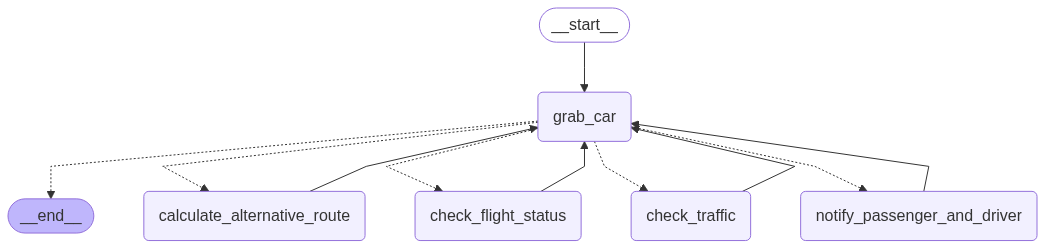

In [18]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

Members: ['handle_traffic_dispute', 'airport_pickup_assistance', 'communicate']
Options: ['handle_traffic_dispute', 'airport_pickup_assistance', 'communicate', 'END']
Updated Options: ['handle_traffic_dispute', 'airport_pickup_assistance', 'communicate', 'END']

Router class definition uses: END


END constant value: '__end__'
Type of END: <class 'str'>
Is END a string? True
END in globals? True

Imports from langgraph.graph:
  END: <class 'str'>
  MessageGraph: <class 'type'>
  MessagesState: <class 'typing_extensions._TypedDictMeta'>
  START: <class 'str'>
  StateGraph: <class 'type'>
  add_messages: <class 'function'>
  message: <class 'module'>
  state: <class 'module'>
